In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
bank = pd.read_csv("C:/Users/akabo/Downloads/intro to business analysis/Final Project/Bank_Personal_Loan_Modelling.csv")
bank.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,...,Online,CreditCard,Experience Median_x,Area,Experience Median_y,Experience Median_x,Experience Median_y,Experience Median_x,Experience Median_y,Experience Median


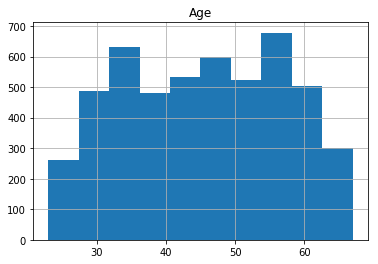

In [72]:
bank.hist("Age")
Wrong = bank.loc[(bank.Experience <0)]
Wrong.head()

In [5]:
bank['ZIP Code'] = bank['ZIP Code'].astype(np.str)
print(bank['ZIP Code'].value_counts(dropna=False).head())
print(len(bank['ZIP Code'].unique()))
# ZIP Code
bank['ZIP Code'] = bank['ZIP Code'].astype(str)
bank['Area'] = bank['ZIP Code'].str.slice(0, 3)
bank['Area'] = bank['Area'].astype('category')
bank['ZIP Code'] = bank['ZIP Code'].astype('category')

94720    169
94305    127
95616    116
90095     71
93106     57
Name: ZIP Code, dtype: int64
467


In [6]:
bank_Age = bank[bank.Experience >= 0].groupby('Age').Experience.median().to_frame('Experience Median').reindex()

bank = pd.merge(bank, bank_Age, on = "Age", how = "left")

# Cleaning
bank.loc[bank.Experience < 0,'Experience'] = np.round(bank['Experience Median'])

# 23 years old == null
bank.loc[bank.Experience.isnull(), 'Experience'] = 0

In [83]:
#bank['Education'] = bank['Education'].astype('category')
#bank['Family'] = bank['Family'].astype('category')

In [8]:
bank['Family'].values
bank.dtypes

array([4, 3, 1, ..., 2, 3, 3], dtype=int64)

In [15]:
familydummy = pd.get_dummies(bank['Family'], prefix='Family')
bank_family = pd.concat([bank, familydummy], axis=1)      
bank_family.drop(['Family_4'], inplace=True, axis=1)

In [18]:
edudummy =  pd.get_dummies(bank_family['Education'], prefix='Education')
bank_edu = pd.concat([bank_family, edudummy], axis=1)      
bank_edu.drop(['Education_3'], inplace=True, axis=1)

In [20]:
bank_edu.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,...,CD Account,Online,CreditCard,Area,Experience Median,Family_1,Family_2,Family_3,Education_1,Education_2
0,1,25,1.0,49,91107,4,1.6,1,0,0,...,0,0,0,911,1.0,0,0,0,1,0
1,2,45,19.0,34,90089,3,1.5,1,0,0,...,0,0,0,900,20.0,0,0,1,1,0
2,3,39,15.0,11,94720,1,1.0,1,0,0,...,0,0,0,947,14.0,1,0,0,1,0
3,4,35,9.0,100,94112,1,2.7,2,0,0,...,0,0,0,941,10.0,1,0,0,0,1
4,5,35,8.0,45,91330,4,1.0,2,0,0,...,0,0,1,913,10.0,0,0,0,0,1


In [21]:
import graphviz 
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(bank_edu.iloc[:, 0:12], bank_edu['Personal Loan'], test_size =0.3,random_state=0)

In [50]:
from sklearn.tree import DecisionTreeClassifier # A decision tree classifier
# GridSearchCV performs an exhaustive search over specified parameter values for an estimator
# The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.
from sklearn.model_selection import GridSearchCV #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.linear_model import LogisticRegression 
from sklearn import neighbors, datasets
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
gs_dt2 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None], 'criterion':['gini','entropy'], 
                              'min_samples_leaf':[1,2,3,4,5],
                              'min_samples_split':[2,3,4,5]}],
                  scoring='accuracy',
                  cv=10,
                  n_jobs=4)

gs_dt2 = gs_dt2.fit(X_train,y_train)
print(gs_dt2.best_score_)
print(gs_dt2.best_params_)


0.9854285714285714
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [45]:
gs_lr2 = GridSearchCV(estimator=LogisticRegression(random_state=0),
                  param_grid=[{'C': [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000, 10000000],
                             'penalty':['l1','l2']}],
                  scoring='accuracy',
                  cv=10)

gs_lr2 = gs_lr2.fit(X_train,y_train)
print(gs_lr2.best_score_)
print(gs_lr2.best_params_)


0.9494285714285714
{'C': 10, 'penalty': 'l2'}


In [54]:
#Normalize Data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Choosing k for kNN AND type of distance
gs_knn2 = GridSearchCV(estimator=neighbors.KNeighborsClassifier(p=2, 
                           metric='minkowski'),
                  param_grid=[{'n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
                               'weights':['uniform','distance']}],
                  scoring='accuracy',
                  cv=10,
                  n_jobs=4)
gs_knn2 = gs_knn2.fit(X_train_std, y_train)          
print(gs_knn2.best_score_)
print(gs_knn2.best_params_)
print(gs_knn2.best_estimator_)

0.9525714285714286
{'n_neighbors': 5, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')


In [35]:
clf_gs = tree.DecisionTreeClassifier(criterion = 'entropy',
                                     max_depth =4,
                                     min_samples_leaf = 3,
                                     min_samples_split = 2)
                                     
clf_lr = LogisticRegression(penalty='l2',C=10)

clf_knn =neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [55]:
from sklearn.model_selection import cross_val_score

scores_gs=cross_val_score(clf_gs, X_train,y_train, 
                         scoring='accuracy', cv=10)
print('CV gs accuracy: %.3f +/- %.3f' % (np.mean(scores_gs),
                                      np.std(scores_gs)))


scores_lr=cross_val_score(clf_lr, X_train,y_train, 
                         scoring='accuracy', cv=10)
print('CV lr accuracy: %.3f +/- %.3f' % (np.mean(scores_lr),
                                      np.std(scores_lr)))

scores_knn=cross_val_score(clf_knn, X_train,y_train, 
                         scoring='accuracy', cv=10)
print('CV knn accuracy: %.3f +/- %.3f' % (np.mean(scores_knn),
                                      np.std(scores_knn)))





CV gs accuracy: 0.984 +/- 0.005
CV lr accuracy: 0.950 +/- 0.007
CV knn accuracy: 0.898 +/- 0.016


In [87]:
y_pred = clf_gs.fit(X_train, y_train).predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
Confusion_Matrix = pd.DataFrame(confusion_matrix(y_test,y_pred))
print(Confusion_Matrix)
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

      0    1
0  1362   10
1    16  112
Accuracy (out-of-sample): 0.98
F1 score (out-of-sample):  0.8959999999999999
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1372
          1       0.92      0.88      0.90       128

avg / total       0.98      0.98      0.98      1500



In [65]:
y_pred = clf_lr.fit(X_train, y_train).predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
Confusion_Matrix = pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["1","0"],index=["1","0"])
print(Confusion_Matrix)
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

      1   0
1  1353  19
0    50  78
Accuracy (out-of-sample): 0.95
F1 score (out-of-sample):  0.6933333333333334
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1372
          1       0.80      0.61      0.69       128

avg / total       0.95      0.95      0.95      1500



In [88]:
y_pred = clf_knn.fit(X_train, y_train).predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
Confusion_Matrix = pd.DataFrame(confusion_matrix(y_test,y_pred))
print(Confusion_Matrix)
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

      0   1
0  1325  47
1    85  43
Accuracy (out-of-sample): 0.91
F1 score (out-of-sample):  0.39449541284403666
             precision    recall  f1-score   support

          0       0.94      0.97      0.95      1372
          1       0.48      0.34      0.39       128

avg / total       0.90      0.91      0.90      1500



10-fold cross validation:

ROC AUC: 0.96 (+/- 0.01) [Logistic regression]
ROC AUC: 0.99 (+/- 0.01) [Decision tree]
ROC AUC: 0.86 (+/- 0.04) [KNN]


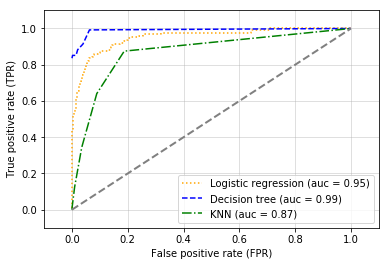

In [61]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Logistic Regression Classifier
clf1 = LogisticRegression(penalty='l2', 
                          C=10,
                          random_state=1)

# Decision Tree Classifier
clf2 = DecisionTreeClassifier(max_depth=4,
                              criterion='entropy',
                              random_state=0)

# kNN Classifier
clf3 = KNeighborsClassifier(n_neighbors=5,
                            p=2,
                            metric='minkowski')

# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
all_clf = [clf1, clf2, clf3]

print('10-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3], clf_labels): #For all classifiers 
    scores = cross_val_score(estimator=clf,  #Estimate AUC based on cross validation
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" #Print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

colors = [ 'orange', 'blue', 'green']      #Colors for visualization
linestyles = [':', '--', '-.', '-']        #Line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()

In [62]:
X_imb = pd.concat([X_train, y_train], axis = 1)
X_imb = X_imb.rename(columns={'Personal Loan': 'y_imb'})
y_imb = X_imb['y_imb']

from sklearn.utils import resample

# Number of class 1 samples before

print('Number of class 1 samples before:', X_imb[y_imb == '1'].shape[0])

# Resampling strategy = take the minority class from the imbalanced data set and repeatedly draw samples
# from it until it contains the same number of samples as class label 0

X_upsampled, y_upsampled = resample(X_imb[y_imb == '1'], # Indexable data-structures as input
                                    y_imb[y_imb == '1'],
                                    replace=True, # Implements resampling with replacement.
                                    n_samples=X_imb[y_imb == '0'].shape[0], # Number of samples to generate.
                                    random_state=0) # The seed of the pseudo random number generator to use when shuffling the data

# Number of class 1 samples after oversampling rare class
print('Number of class 1 samples after:', X_upsampled.shape[0])

NameError: name 'X_imb' is not defined

In [64]:
# After resampling, we can stack the original class 0 with the upsampled class 1 subset to obtain a balanced dataset
# as follows:

X_bal = np.vstack((X_imb[y_imb == '0'], X_upsampled))
y_bal = np.hstack((y_imb[y_imb == '0'], y_upsampled))

# Consequently if we were to predict the accuracy of the model that always predicts the majority class ~50%
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

NameError: name 'X_imb' is not defined